In [1]:
# import
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from math import ceil
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# load data
# 14 discrete
discrete = ["YearBuilt", "YearRemodAdd", "BsmtFullBath", "BsmtHalfBath", 
            "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr",
            "TotRmsAbvGrd", "Fireplaces", "GarageYrBlt", "GarageCars", 
            "MoSold", "YrSold"]
# 20 continuous
continuous = ["LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", 
              "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", 
              "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea", 
              "WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", 
              "ScreenPorch", "PoolArea", "MiscVal", "SalePrice"]

df_train = pd.read_csv("train.csv", index_col="Id")
df_test = pd.read_csv("test.csv", index_col="Id")
df_train.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1266,160,FV,35.0,3735,Pave,NaN,Reg,Lvl,AllPub,FR3,...,0,NaN,NaN,NaN,0,3,2006,WD,Normal,183900
1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,Corner,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
747,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
977,30,RL,51.0,5900,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2006,WD,Normal,85500
895,90,RL,64.0,7018,Pave,NaN,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2009,WD,Alloca,118858


In [3]:
missing = []
cols = discrete + continuous
cols.remove("SalePrice")
for col in cols:
    cnt = df_train[col].isnull().sum() + df_test[col].isnull().sum()
    if cnt:
        missing.append(col)
        print("%s: %d" % (col, cnt))

BsmtFullBath: 2
BsmtHalfBath: 2
GarageYrBlt: 159
GarageCars: 1
LotFrontage: 486
MasVnrArea: 23
BsmtFinSF1: 1
BsmtFinSF2: 1
BsmtUnfSF: 1
TotalBsmtSF: 1
GarageArea: 1


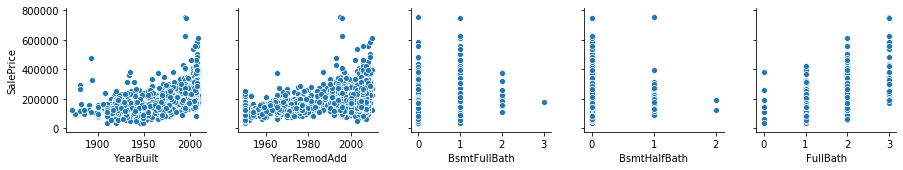

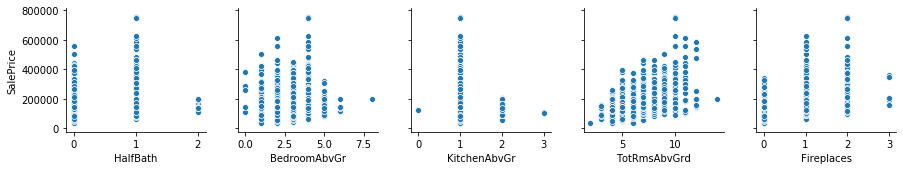

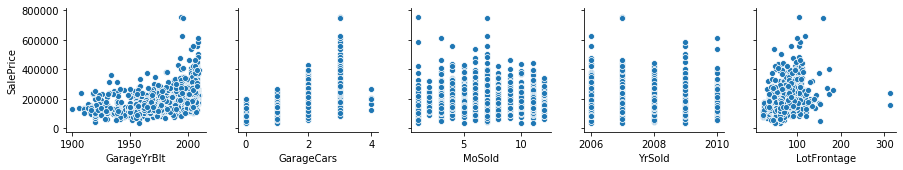

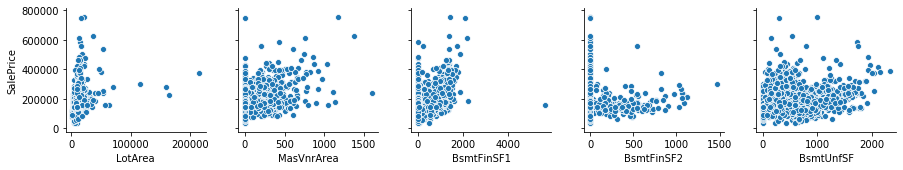

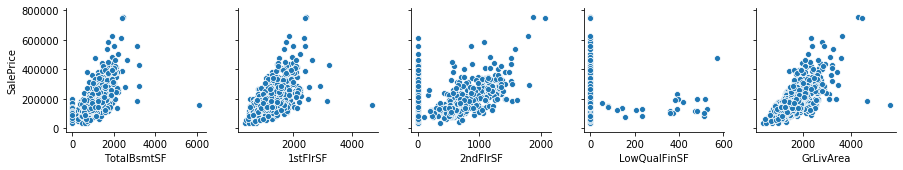

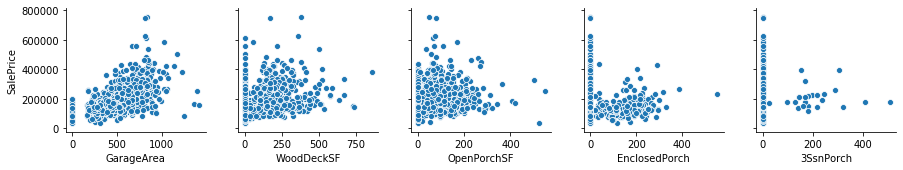

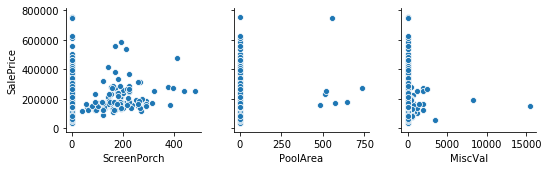

In [4]:
# chunks
def chunks(l, n):
    return [l[i:i + n] for i in range(0, len(l), n)]
cols = discrete + continuous
cols.remove('SalePrice')
data = pd.concat([df_train['SalePrice'], df_train[cols]], axis=1)
for lst in chunks(cols, 5):
    sns.pairplot(data, y_vars=['SalePrice'], x_vars=lst)

outliers = {"LotArea": 150000, "BsmtFinSF1": 4000, "TotalBsmtSF": 6000, 
            "1stFlrSF": 4000, "GrLivArea": 5000}

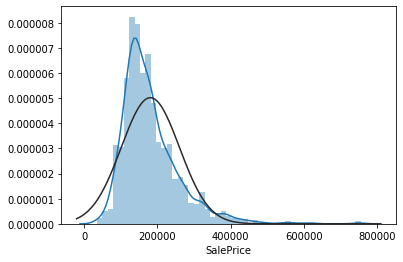

In [5]:
sns.distplot(df_train['SalePrice'], fit=norm);

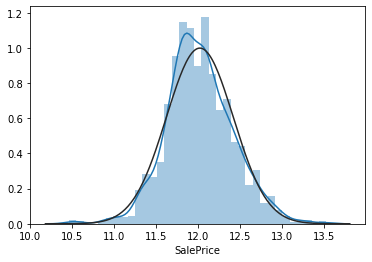

In [6]:
sns.distplot(np.log1p(df_train['SalePrice']), fit=norm);

In [7]:
# impute missing values
def impute(df, cols):
    for col in cols:
        df[col] = df[col].fillna(df[col].mean())

impute(df_train, missing)
impute(df_test, missing)
df_train.sample(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1104,20,RL,79.0,8910,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,159500
158,60,RL,92.0,12003,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,New,Partial,269500
201,20,RM,80.0,8546,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,3,2010,WD,Normal,140000
496,30,C (all),60.0,7879,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdWo,NaN,0,11,2009,WD,Abnorml,34900
671,60,RL,64.0,8633,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,2,2009,WD,Normal,173500


In [8]:
# clean outliers
def clean_outliers(df, outliers):
    for col in outliers:
        df = df[df[col] < outliers[col]]
    return df

print("Before cleaning: %d" % len(df_train))
df_train = clean_outliers(df_train, outliers)
print("After cleaning: %d" % len(df_train))

Before cleaning: 1460
After cleaning: 1456


In [9]:
# discretize
# categorical attributes
categorical = ["MSZoning", "Street", "Alley", "LotShape", "LandContour", 
               "Utilities", "LotConfig", "LandSlope", "Neighborhood", "Condition1",
               "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl",
               "Exterior1st", "Exterior2nd", "MasVnrType", "ExterQual", "ExterCond",
               "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
               "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical",
               "KitchenQual", "Functional", "FireplaceQu", "GarageType", "GarageFinish",
               "GarageQual", "GarageCond", "PavedDrive", "PoolQC", "Fence", "MiscFeature",
               "SaleType", "SaleCondition"]
icategorical = ["MSSubClass", "OverallQual", "OverallCond"]

qual_dict = {"NONE": 0, "Po": 1, "Fa": 2, "TA": 4, "Gd": 7, "Ex": 11}
qual_cols = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", 
             "KitchenQual", "FireplaceQu", "GarageQual", "GarageCond", "PoolQC"]

def discretize(df, cols):
    for col in cols:
        df[col] = df[col].fillna("NONE")
        if col in qual_cols:
            df[col] = df[col].map(qual_dict).astype('int')
        else:
            df[col] = df[col].astype('category')
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

dataset = pd.concat(objs=[df_train, df_test], axis=0)
discretize(dataset, categorical)
idx = len(df_train)
df_train = dataset[:idx]
df_test = dataset[idx:]
df_train.sample(5)

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
413,1478,0,0,1,2,0,4,0,578.0,0.0,...,7,0,1,7,1470.0,0,0,2009,2009,2010
971,720,472,0,1,4,0,4,4,0.0,0.0,...,9,0,1,6,720.0,0,0,1949,1950,2006
1220,672,546,0,1,3,3,4,4,0.0,0.0,...,9,0,1,7,672.0,0,201,1971,1971,2006
269,778,0,0,1,2,0,4,4,403.0,125.0,...,9,0,1,4,740.0,0,0,1940,1955,2008
1238,847,1101,0,1,4,0,4,4,0.0,0.0,...,9,0,1,8,847.0,0,100,2004,2005,2006


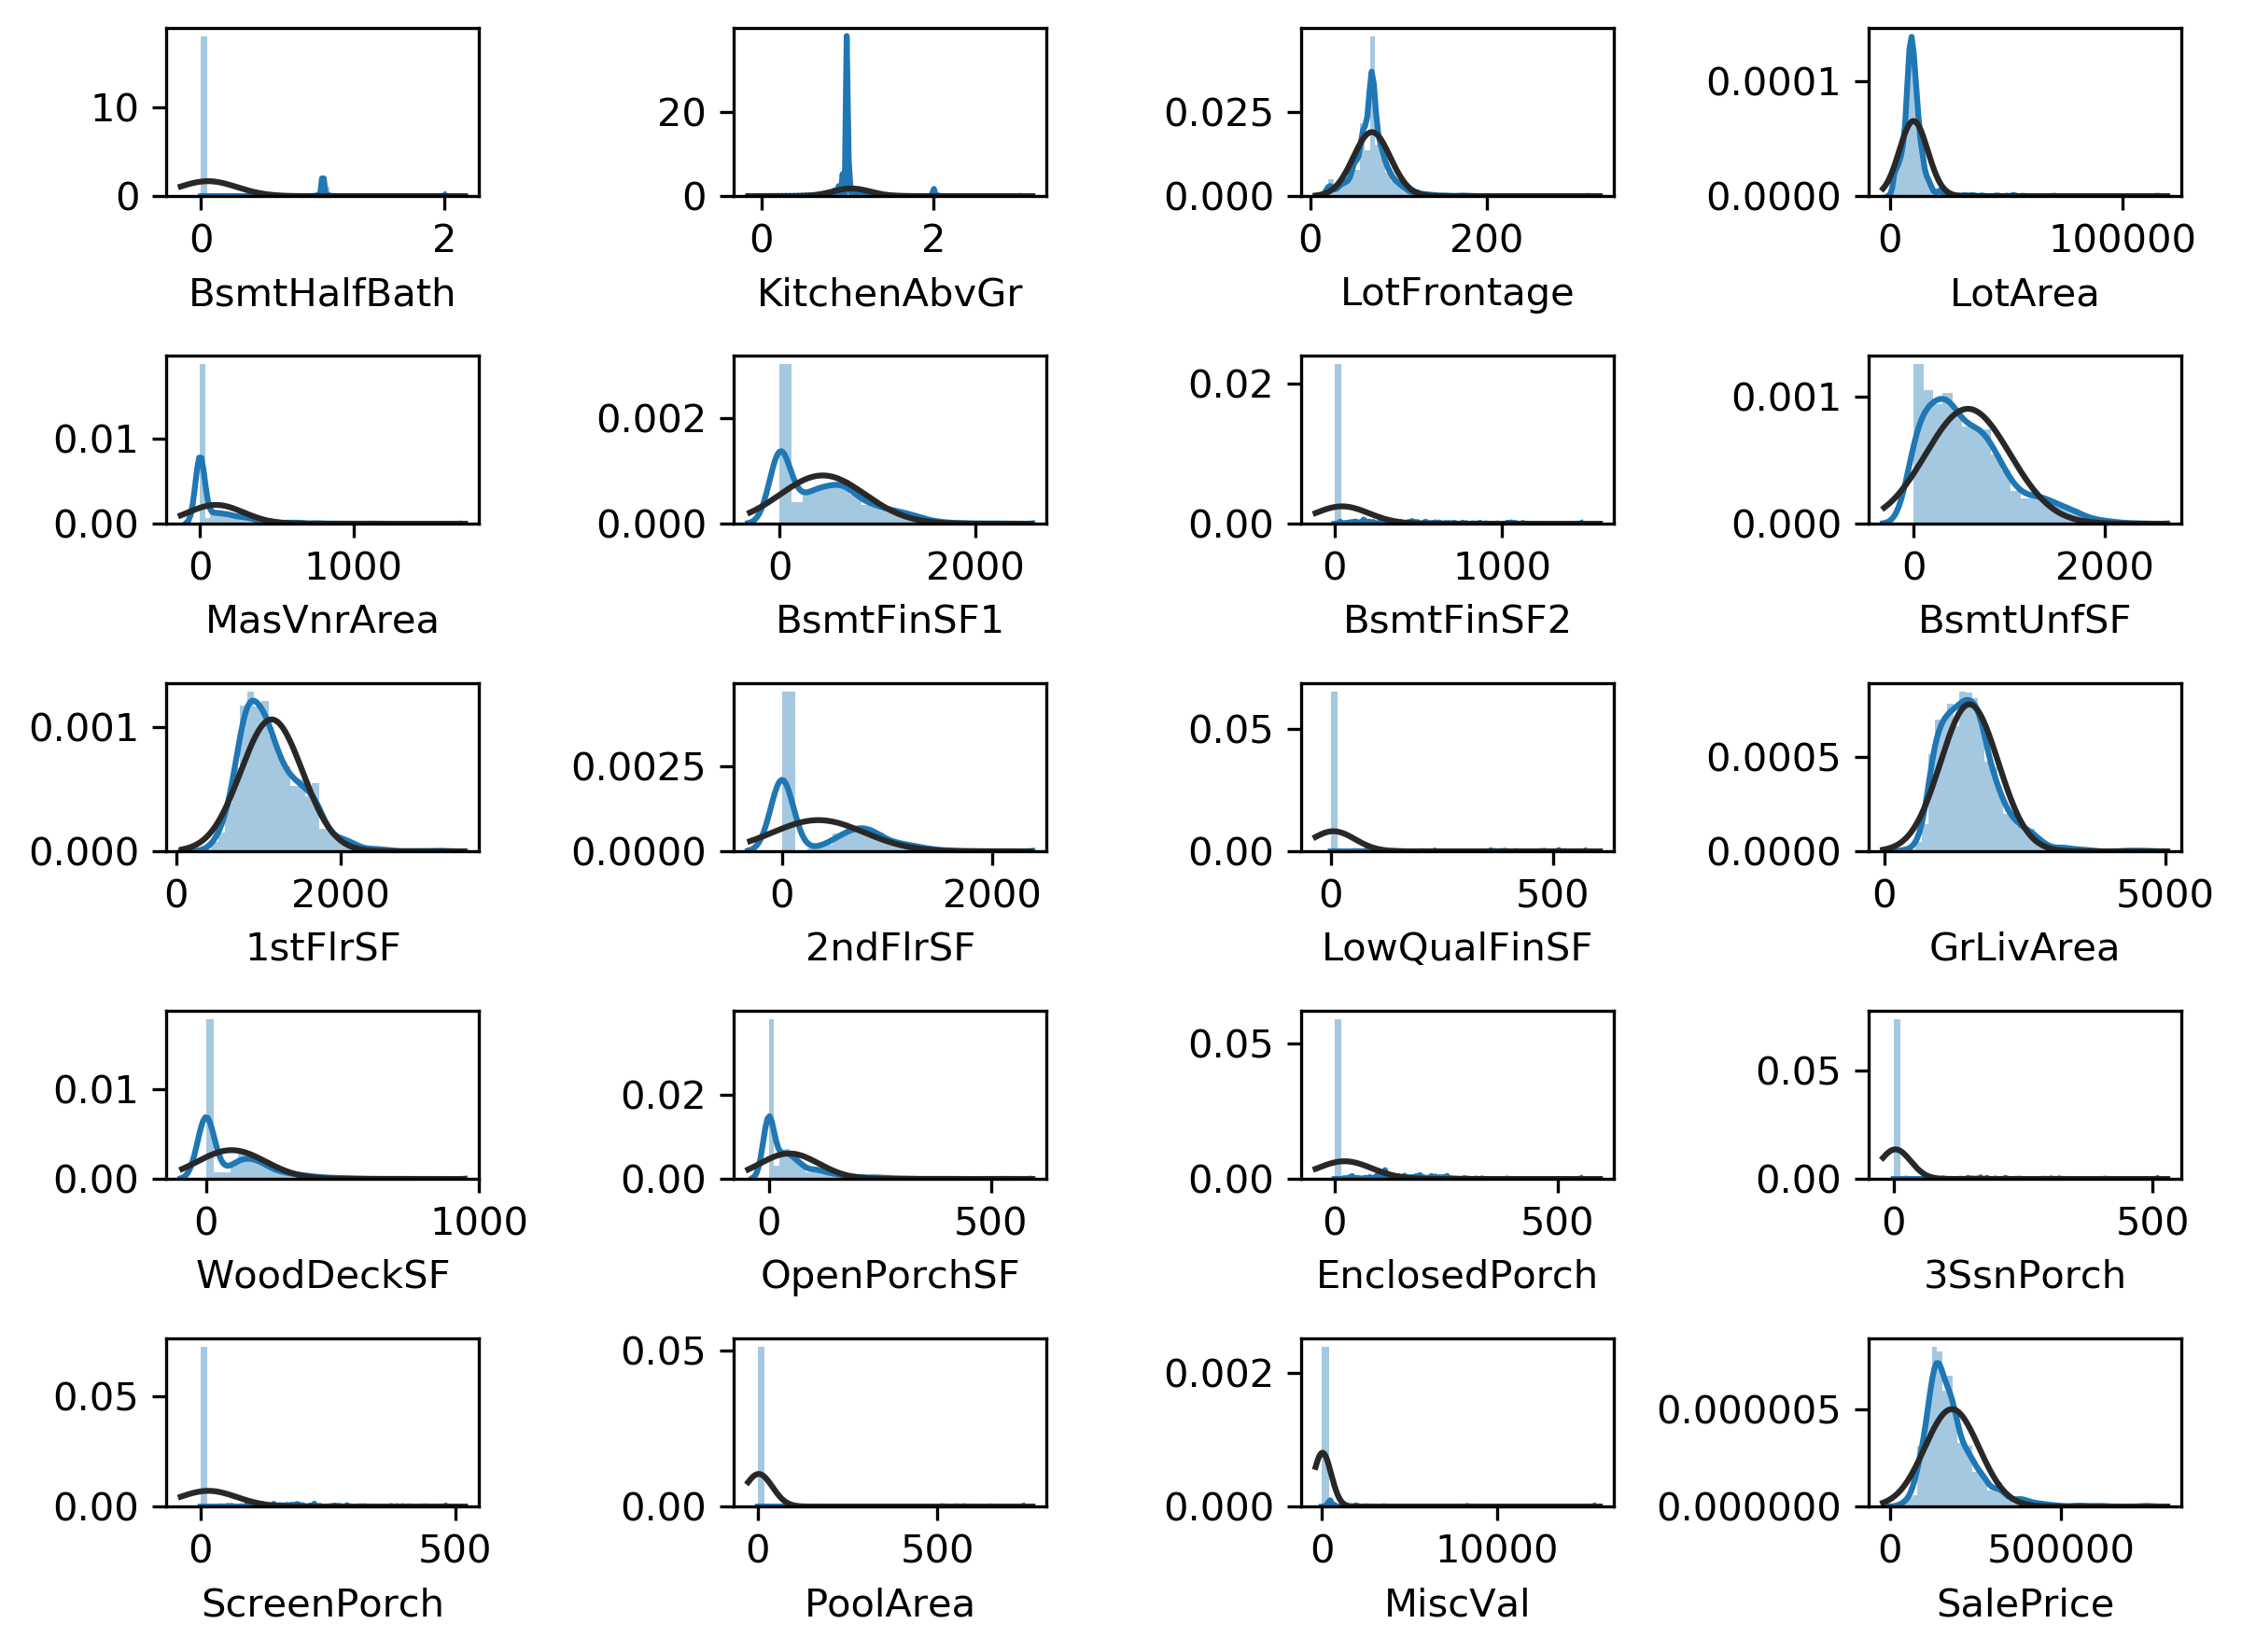

In [10]:
def distplot(df, cols, ncols):
    nrows = ceil(len(cols) / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 6), dpi=300)
    for idx in range(0, len(cols)):
        x = (int) (idx / ncols)
        y = (int) (idx % ncols)
        attr = cols[idx]
        sns.distplot(df[attr], fit=norm, ax=axes.item((x, y)))
    plt.tight_layout()

numeric = discrete + continuous
df_skew = df_train[numeric].apply(lambda x: stats.skew(x.astype('float')))
df_skew = df_skew[abs(df_skew) > 0.75]

# before transformation
distplot(df_train, df_skew.index, 4)

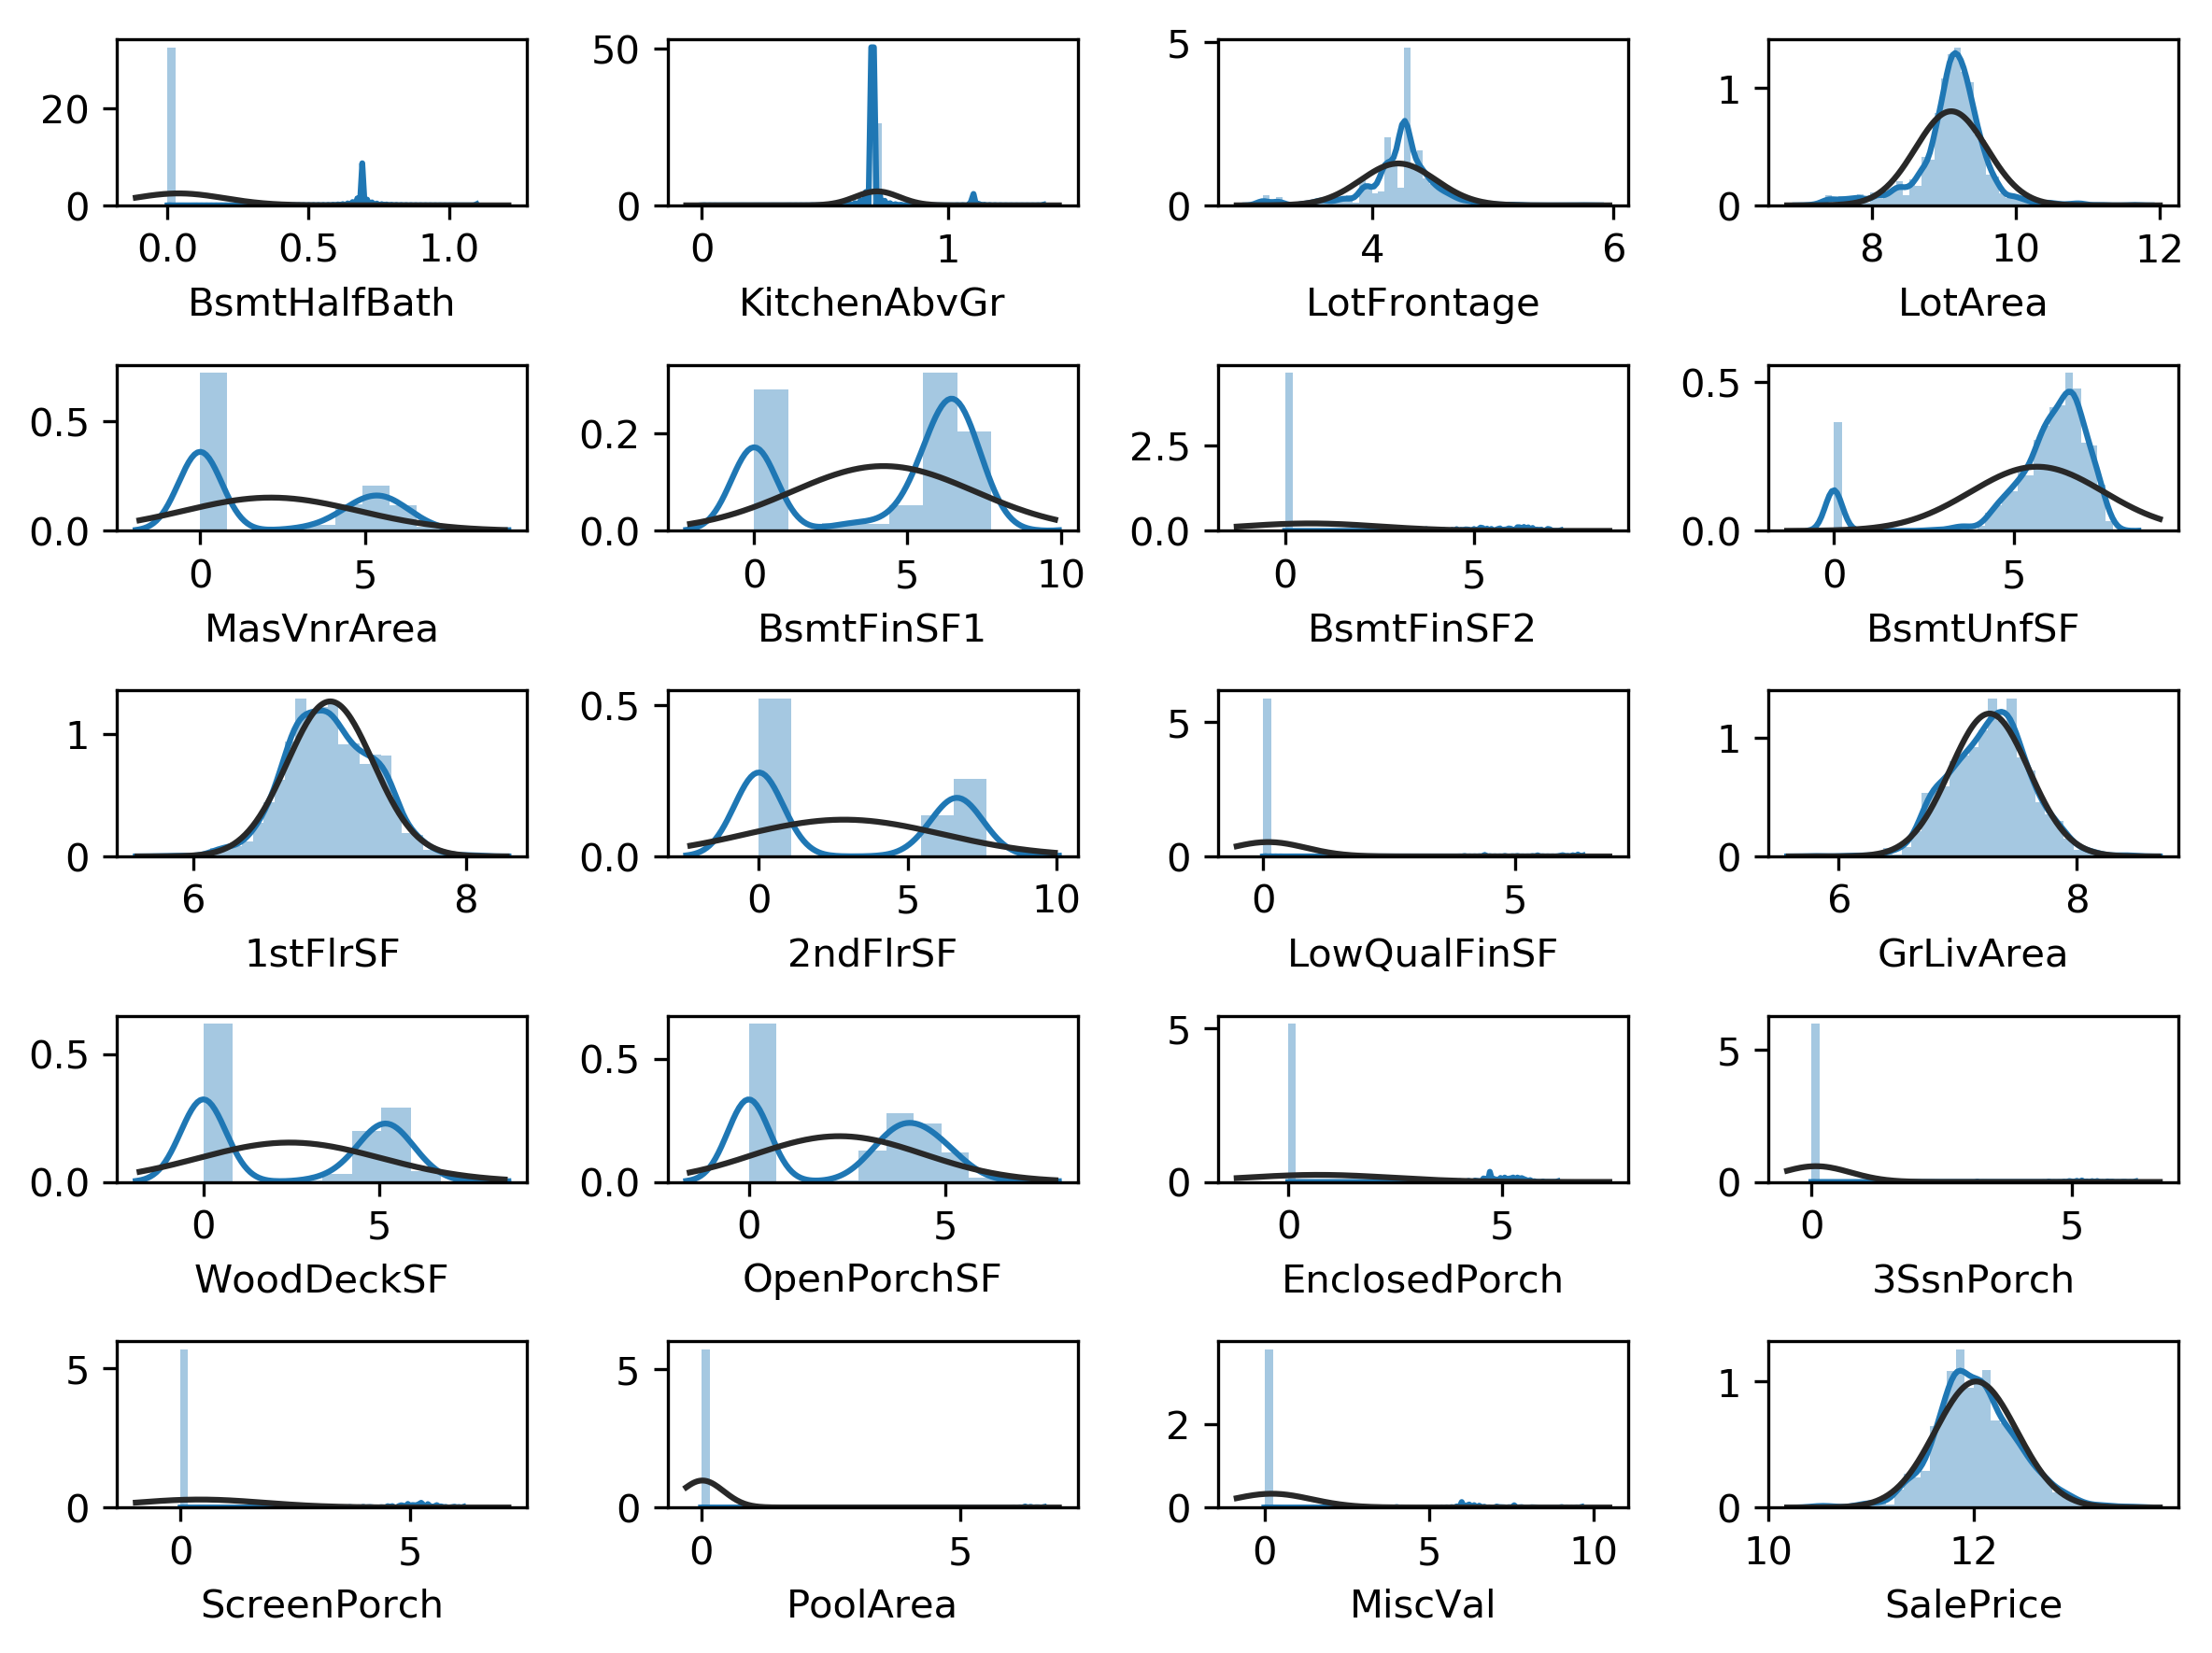

In [11]:
for col in df_skew.index:
    df_train[col] = np.log1p(df_train[col])
    df_test[col] = np.log1p(df_test[col])

# after transformation
distplot(df_train, df_skew.index, 4)

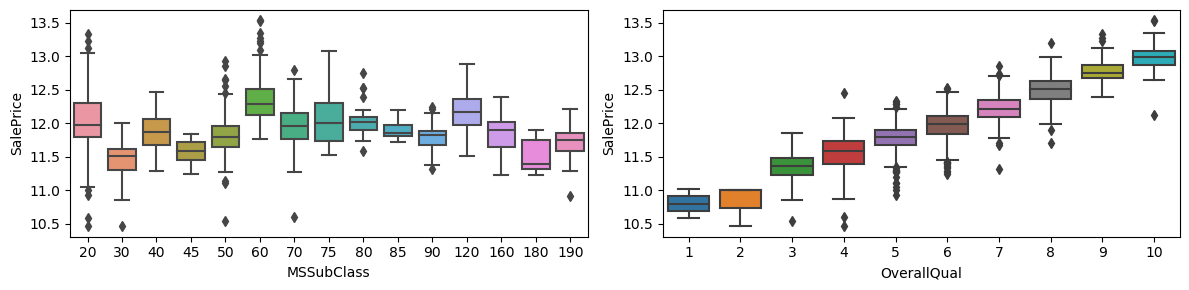

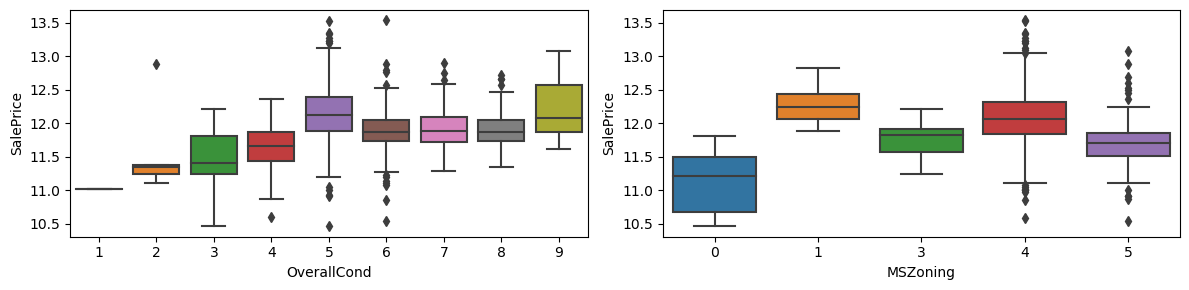

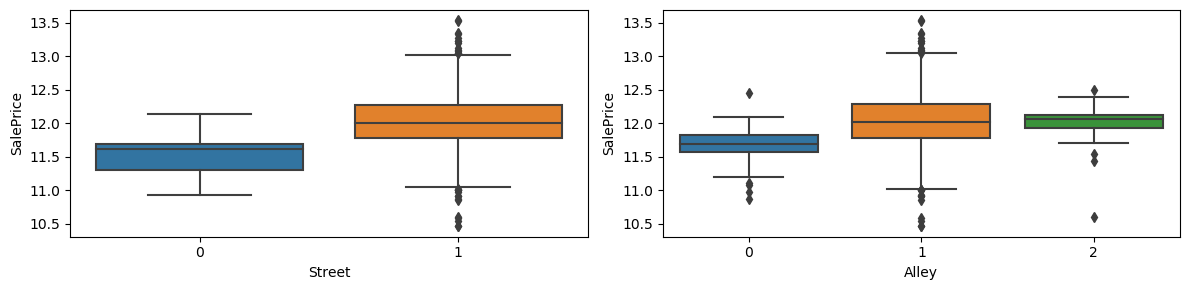

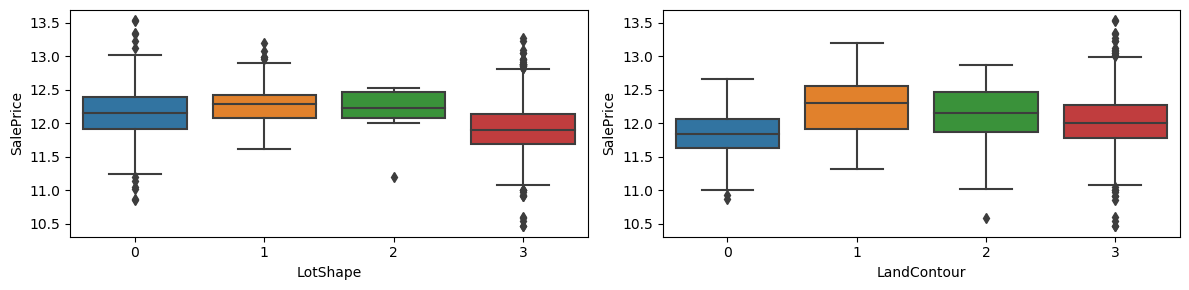

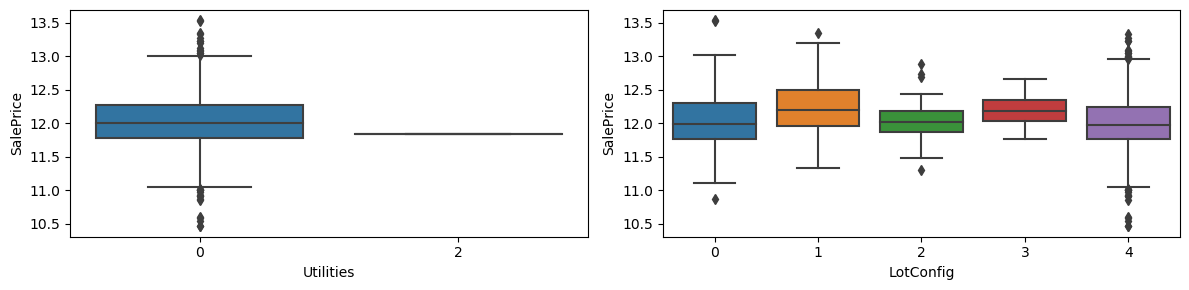

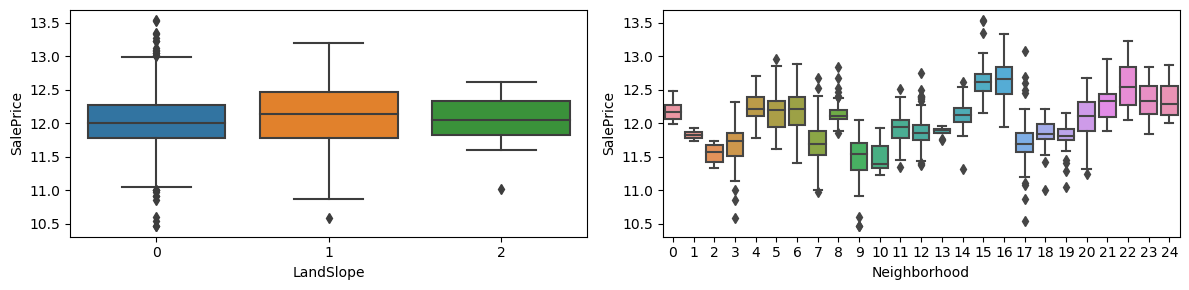

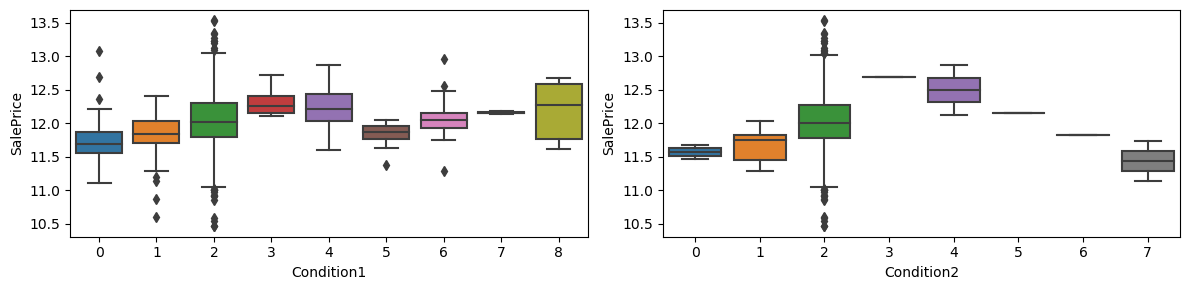

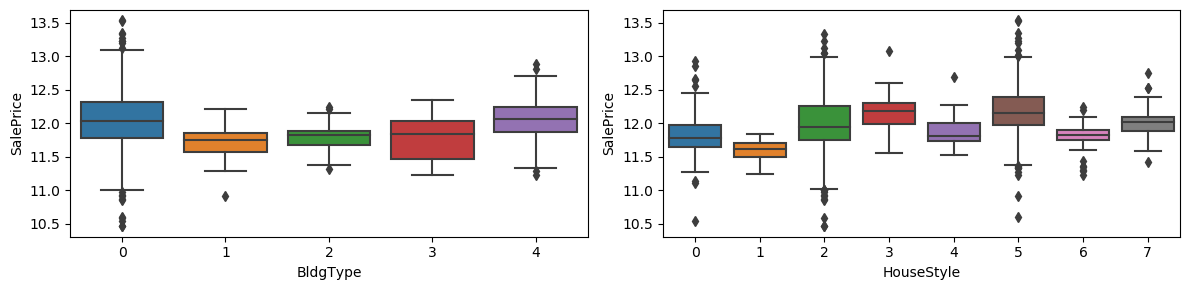

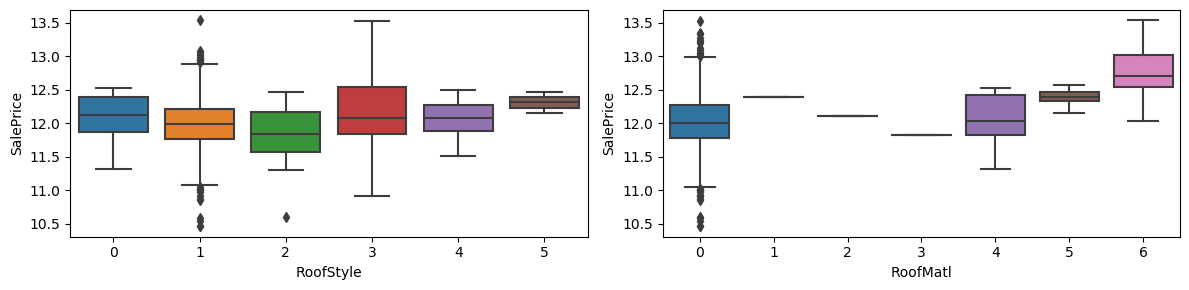

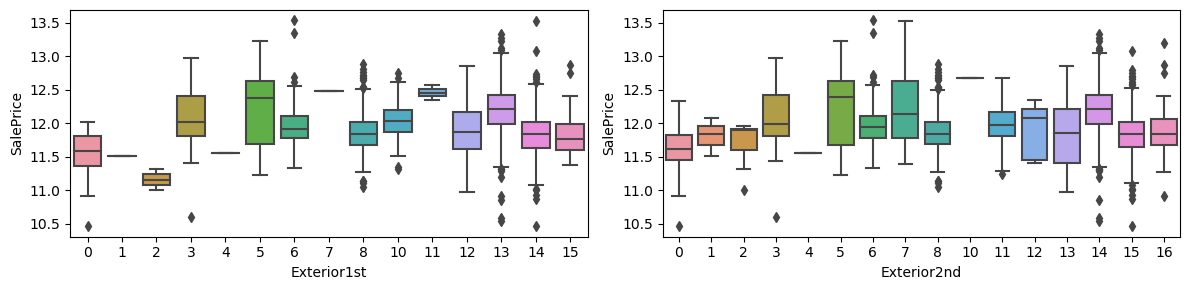

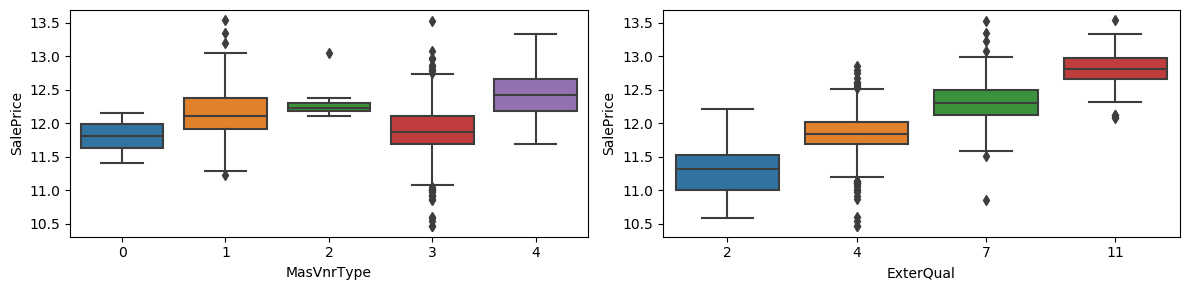

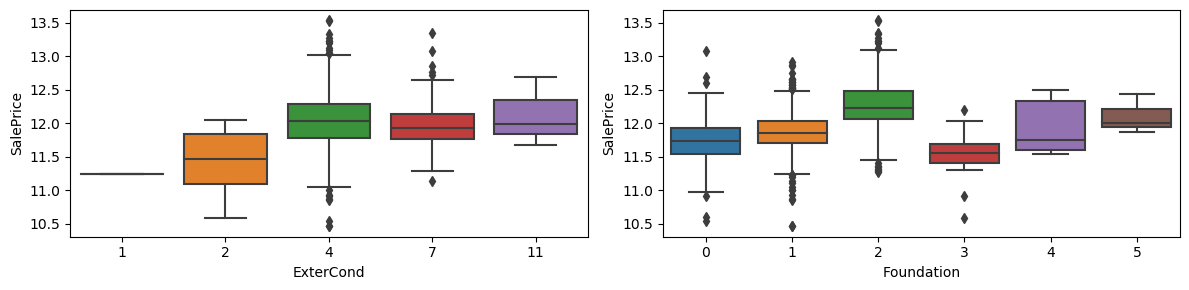

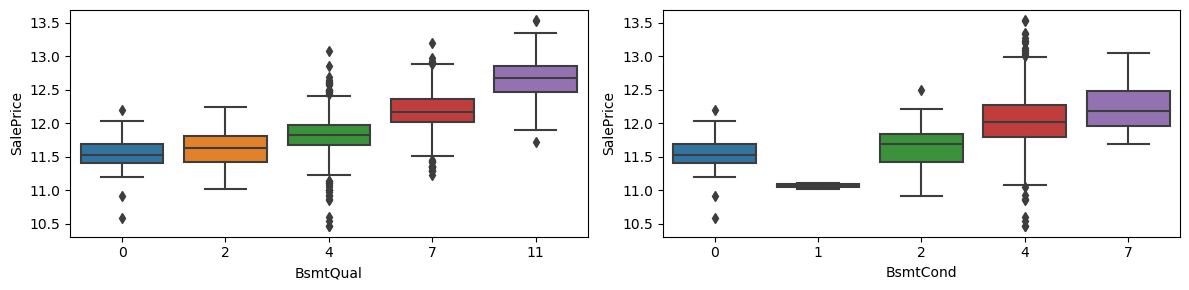

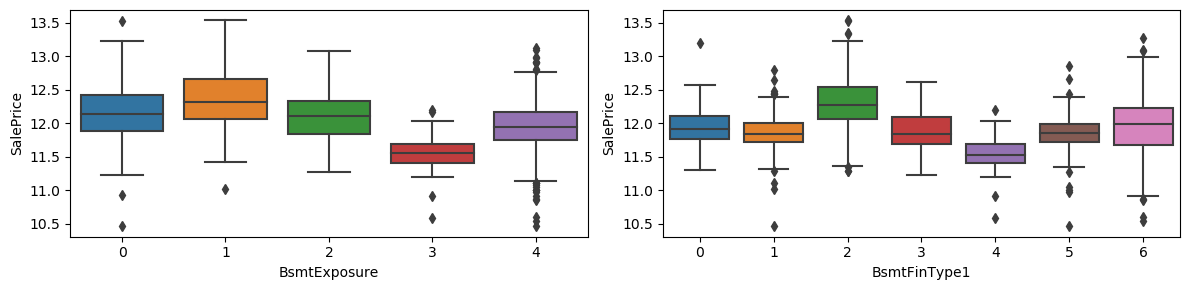

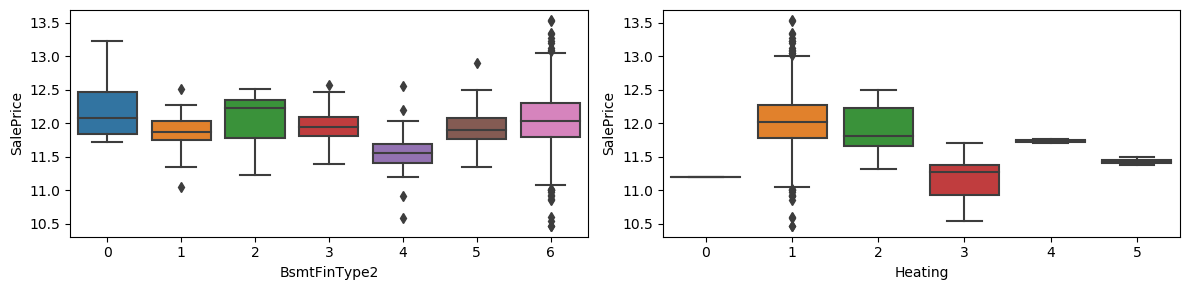

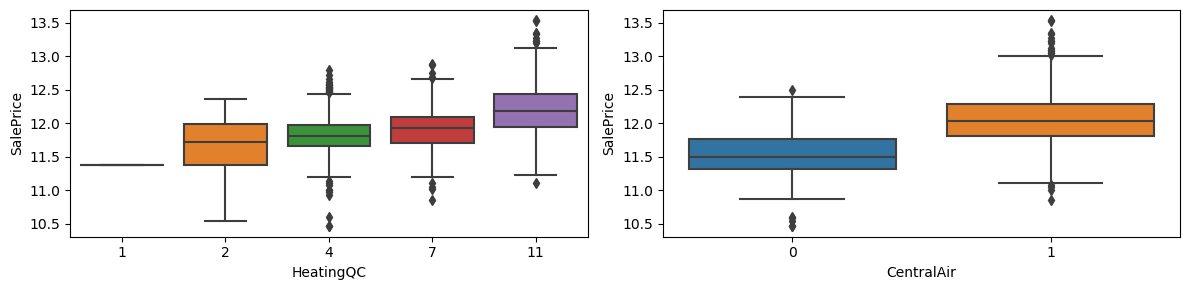

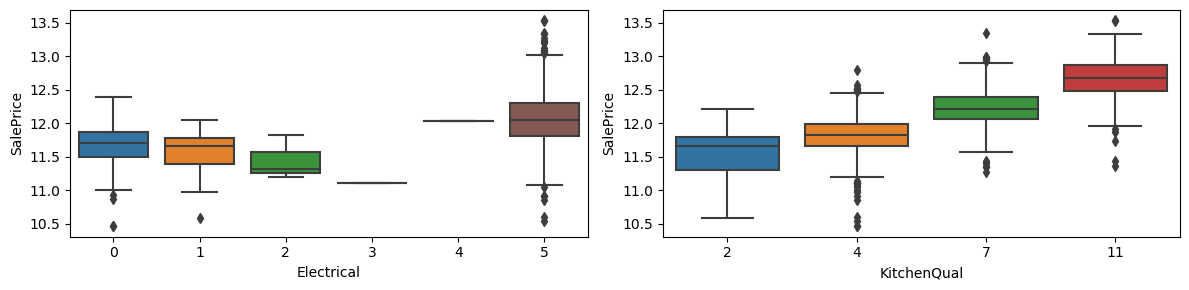

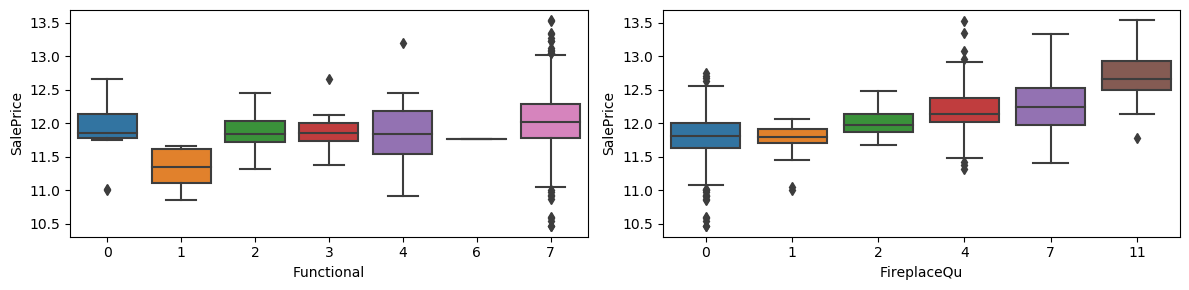

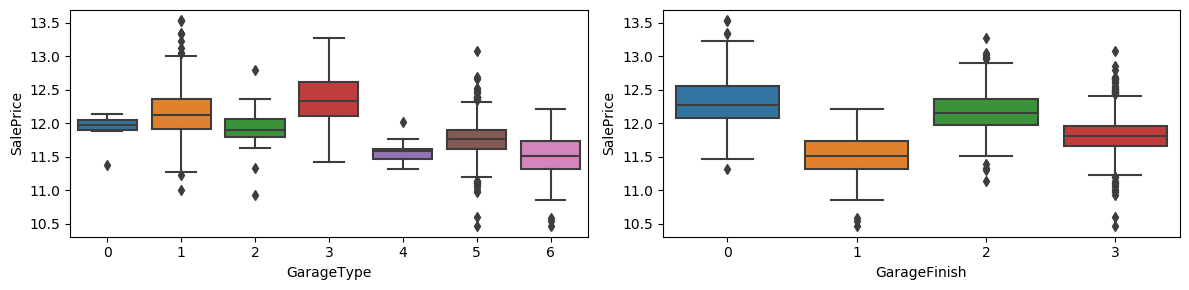

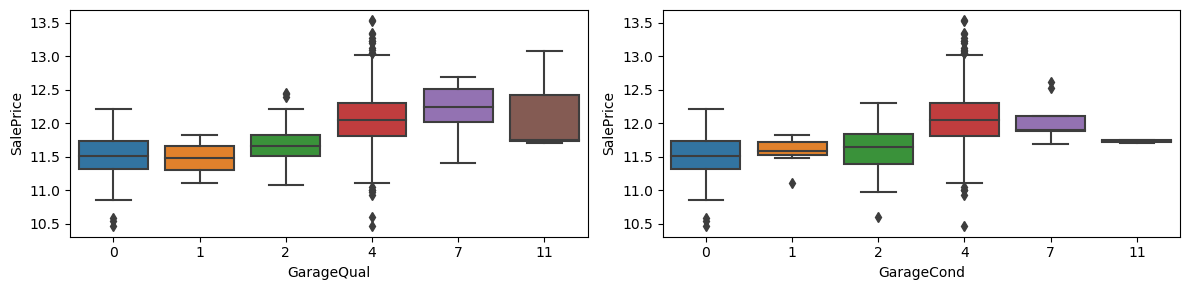

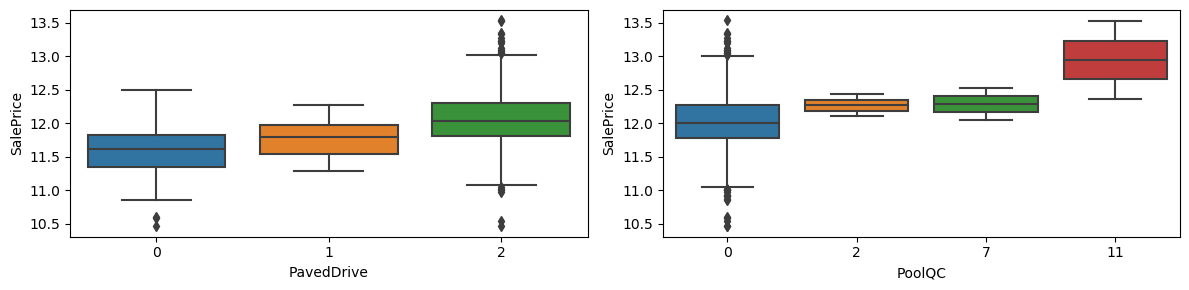

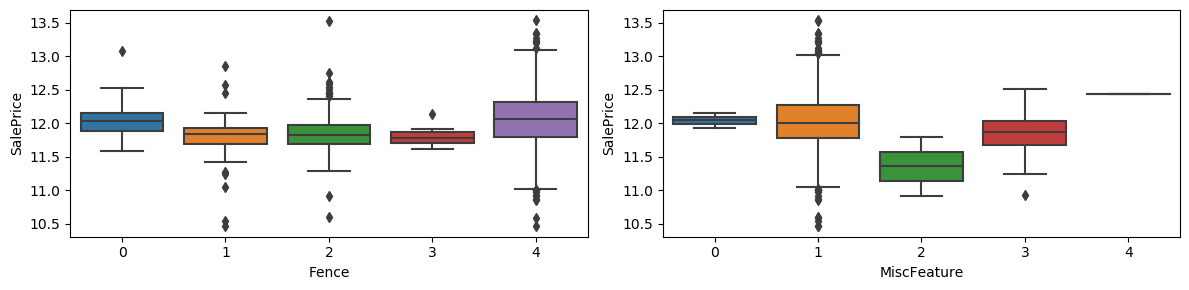

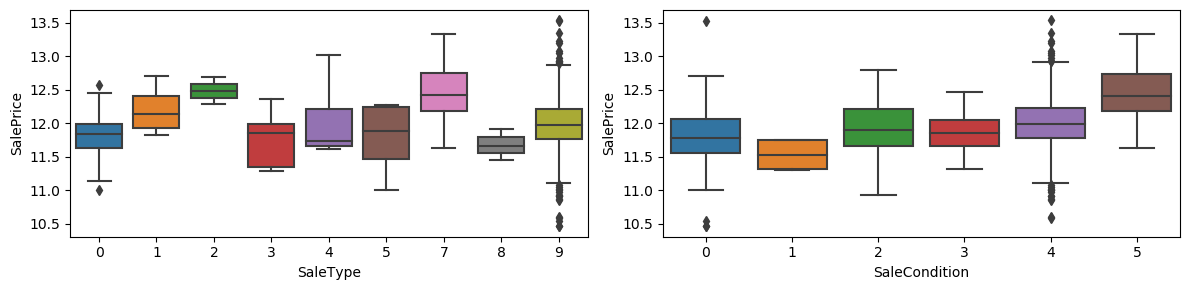

In [12]:
def boxplot(df, cols, ncols):
    for lst in chunks(cols, ncols):
        fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(12, 3), dpi=100)
        for idx in range(0, len(lst)):
            attr = lst[idx]
            data = pd.concat([df['SalePrice'], df[attr]], axis=1)
            sns.boxplot(x=attr, y='SalePrice', data=data, ax=axes[idx])
        plt.tight_layout()

boxplot(df_train, icategorical + categorical, 2)

In [13]:
drops = ["BsmtHalfBath", "KitchenAbvGr", "MasVnrArea", "BsmtFinSF1", 
         "BsmtFinSF2", "2ndFlrSF", "LowQualFinSF", "WoodDeckSF", 
         "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch", 
         "PoolArea", "MiscVal", "Utilities", "Condition2", "RoofMatl"]
df_train = df_train.drop(drops, axis=1)
df_test = df_test.drop(drops, axis=1)
df_test = df_test.drop('SalePrice', axis=1)

In [14]:
corr = df_train.corr()
cols = df_train.columns
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        attr1 = cols[i];
        attr2 = cols[j];
        if corr[attr1][attr2] > 0.7:
            print("(%s, %s): %.2f" % (attr1, attr2, corr[attr1][attr2]))

(1stFlrSF, TotalBsmtSF): 0.78
(BldgType, MSSubClass): 0.75
(ExterQual, KitchenQual): 0.72
(ExterQual, OverallQual): 0.72
(Exterior1st, Exterior2nd): 0.86
(FireplaceQu, Fireplaces): 0.80
(GarageArea, GarageCars): 0.89
(GarageCond, GarageQual): 0.90
(GarageYrBlt, YearBuilt): 0.78
(GrLivArea, SalePrice): 0.73
(GrLivArea, TotRmsAbvGrd): 0.82
(OverallQual, SalePrice): 0.82


In [15]:

drops = ["BldgType", "ExterQual", "GarageYrBlt", "Exterior2nd", "KitchenQual", 
         "1stFlrSF", "TotRmsAbvGrd", "FireplaceQu", "GarageCars", "GarageCond"]
df_train = df_train.drop(drops, axis=1)
df_test = df_test.drop(drops, axis=1)

In [16]:
df_train.shape

(1456, 53)

In [17]:
df_test.shape

(1459, 52)

In [18]:
# evaluate with k-fold cross validation, and report RMSE score
def evaluate(model, X, y, k=10):
    kf = KFold(n_splits=k, shuffle=True, random_state=2)
    y_pr = np.zeros((X.shape[0],))
    for train_index, test_index in kf.split(X):
        X_tr, X_te = X.iloc[train_index], X.iloc[test_index]
        y_tr, y_te = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_tr, y_tr)
        y_pr[test_index] = model.predict(X_te)
    err = sqrt(mean_squared_error(y_pr, y))
    print("RMSE: %.5f" % err)
def coef(model, X):
    for l, r in sorted(zip(X.columns, model.coef_), key=lambda x: abs(x[1]), reverse=True)[:5]:
        print("(%s, %.5f)" % (l, r))
def print_params(est, X, y, n=100):
    print("Chosen parameter on %d datapoints: %s" % 
          (n,est.fit(X[:n], y[:n]).best_params_))
def generate_submission(model, X):
    suffix = model.__class__.__name__.lower()
    y_pr = model.predict(X)
    result = np.exp(y_pr)
    submission = pd.DataFrame({'Id': X.index.values, 'SalePrice': result})
    submission.to_csv("submission_" + suffix + ".csv", index=None)

In [19]:
X_train = df_train.drop("SalePrice", axis=1)
y_train = df_train["SalePrice"]
X_test = df_test
# settings
nJobs = psutil.cpu_count()
kFold = 10

In [20]:
from sklearn.linear_model import Ridge
params = {'max_iter': 50000}
ridge = Ridge(**params)
est = GridSearchCV(ridge, param_grid={"alpha": [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]})
print_params(est, X_train, y_train, 100)

Chosen parameter on 100 datapoints: {'alpha': 10.0}


In [21]:
params = {'alpha': 10.0, 'max_iter': 50000}
ridge = Ridge(**params)
# cross validation
evaluate(ridge, X_train, y_train, kFold)

RMSE: 0.13036


In [22]:
# top 5 attributes
coef(ridge, X_train)

(GrLivArea, 0.28586)
(LotArea, 0.07491)
(OverallQual, 0.07354)
(Street, 0.05653)
(CentralAir, 0.05548)


In [23]:
# generate submission
generate_submission(ridge, X_test)

In [24]:
from sklearn.linear_model import Lasso
params = {'max_iter': 50000}
lasso = Lasso(**params)
est = GridSearchCV(lasso, param_grid={"alpha": np.arange(0.0005, 0.001, 0.00001)})
print_params(est, X_train, y_train, 100)

Chosen parameter on 100 datapoints: {'alpha': 0.0009900000000000013}


In [25]:
params = {'alpha': 0.00099, 'max_iter': 50000}
lasso = Lasso(**params)
# cross validation
evaluate(lasso, X_train, y_train, kFold)

RMSE: 0.12933


In [26]:
coef(lasso, X_train)

(GrLivArea, 0.37070)
(LotArea, 0.07093)
(OverallQual, 0.07050)
(OverallCond, 0.04523)
(Fireplaces, 0.04149)


In [27]:
generate_submission(lasso, X_test)

In [28]:
from sklearn.ensemble import RandomForestRegressor

In [29]:
params = {"n_jobs": nJobs, 'max_depth': 20, 'max_features': 0.3, 
          'min_samples_leaf': 1, 'n_estimators': 800}
rf = RandomForestRegressor(**params)
# cross validation
evaluate(rf, X_train, y_train, kFold)

RMSE: 0.13636


In [30]:
generate_submission(rf, X_test)

In [31]:
from sklearn.ensemble import GradientBoostingRegressor
params = {
    'n_estimators': 3000,
    'learning_rate': 0.05,
    'max_depth': 3,
    'min_samples_leaf': 15,
    'min_samples_split': 10,
    'loss': 'huber',
    'max_features': 'log2'
}
gbdt = GradientBoostingRegressor(**params)
# cross validation
evaluate(gbdt, X_train, y_train, kFold)

RMSE: 0.12453


In [32]:
generate_submission(gbdt, X_test)

In [33]:
from sklearn.neighbors import KNeighborsRegressor
params = {'n_jobs': nJobs, 'n_neighbors': 11, 'algorithm': 'ball_tree'}
knn = KNeighborsRegressor(**params)
# cross validation
evaluate(knn, X_train, y_train, kFold)

RMSE: 0.23447


In [34]:
generate_submission(knn, X_test)